# 1. Introduction 

Collateral Reblance Pool (CRP) dynamically rebalances Collateral to ensure the ayToken minted (i.e. the loan) remains solvent, especially in an adverse market environment (i.e. the value of the loan does not exceed the value of Collateral). This dynamic rebalancing, together with a careful choice of the key parameters (including loan to Loan-to-Value (LTV) and volatility assumption) allows ALEX to eliminate the liquidation needs. Any residual gap risk (which CRP cannot address entirely) is addressed through maintaining a strong reserve fund. When a Borrower mints ayToken by providing appropriate Collateral, the Collateral is converted into a basket of Collateral and Token, with the weights determined by CRP.

In this notebook, we will help you understand the key attributes of the CRP pool by answering: 
1.  How does CRP achieve the dynamic rebalances with weights determined by CRP? 
2.  How does CRP perform in different market environments? 
3.  How does power arbitrageur play a role in the dynamic rebalances and the bring rebate back to the pool.   
3.  In which parameters space (including LTV, volatility assumption, and power arbitrageur functions) and the CRP would maintain a low default risk and a high pool-value level to a collateral ratio (PVTC)?  

Given there is no close form of CPR performance, we use simulation to show the results based on the predicted future scenarios.  


# 2. CRP dynamic rebalance mechanism 

The following diagram illustrates how CRP dynamic rebalances with the weights determined by CRP.  Once the pool updates new weights based on the Black-Scholes option-pricing model, the pool will be rebalanced by Power Arbitrageur to bring the spot price back to the market price. We leave the mathematical formula of the weight to session 5.    
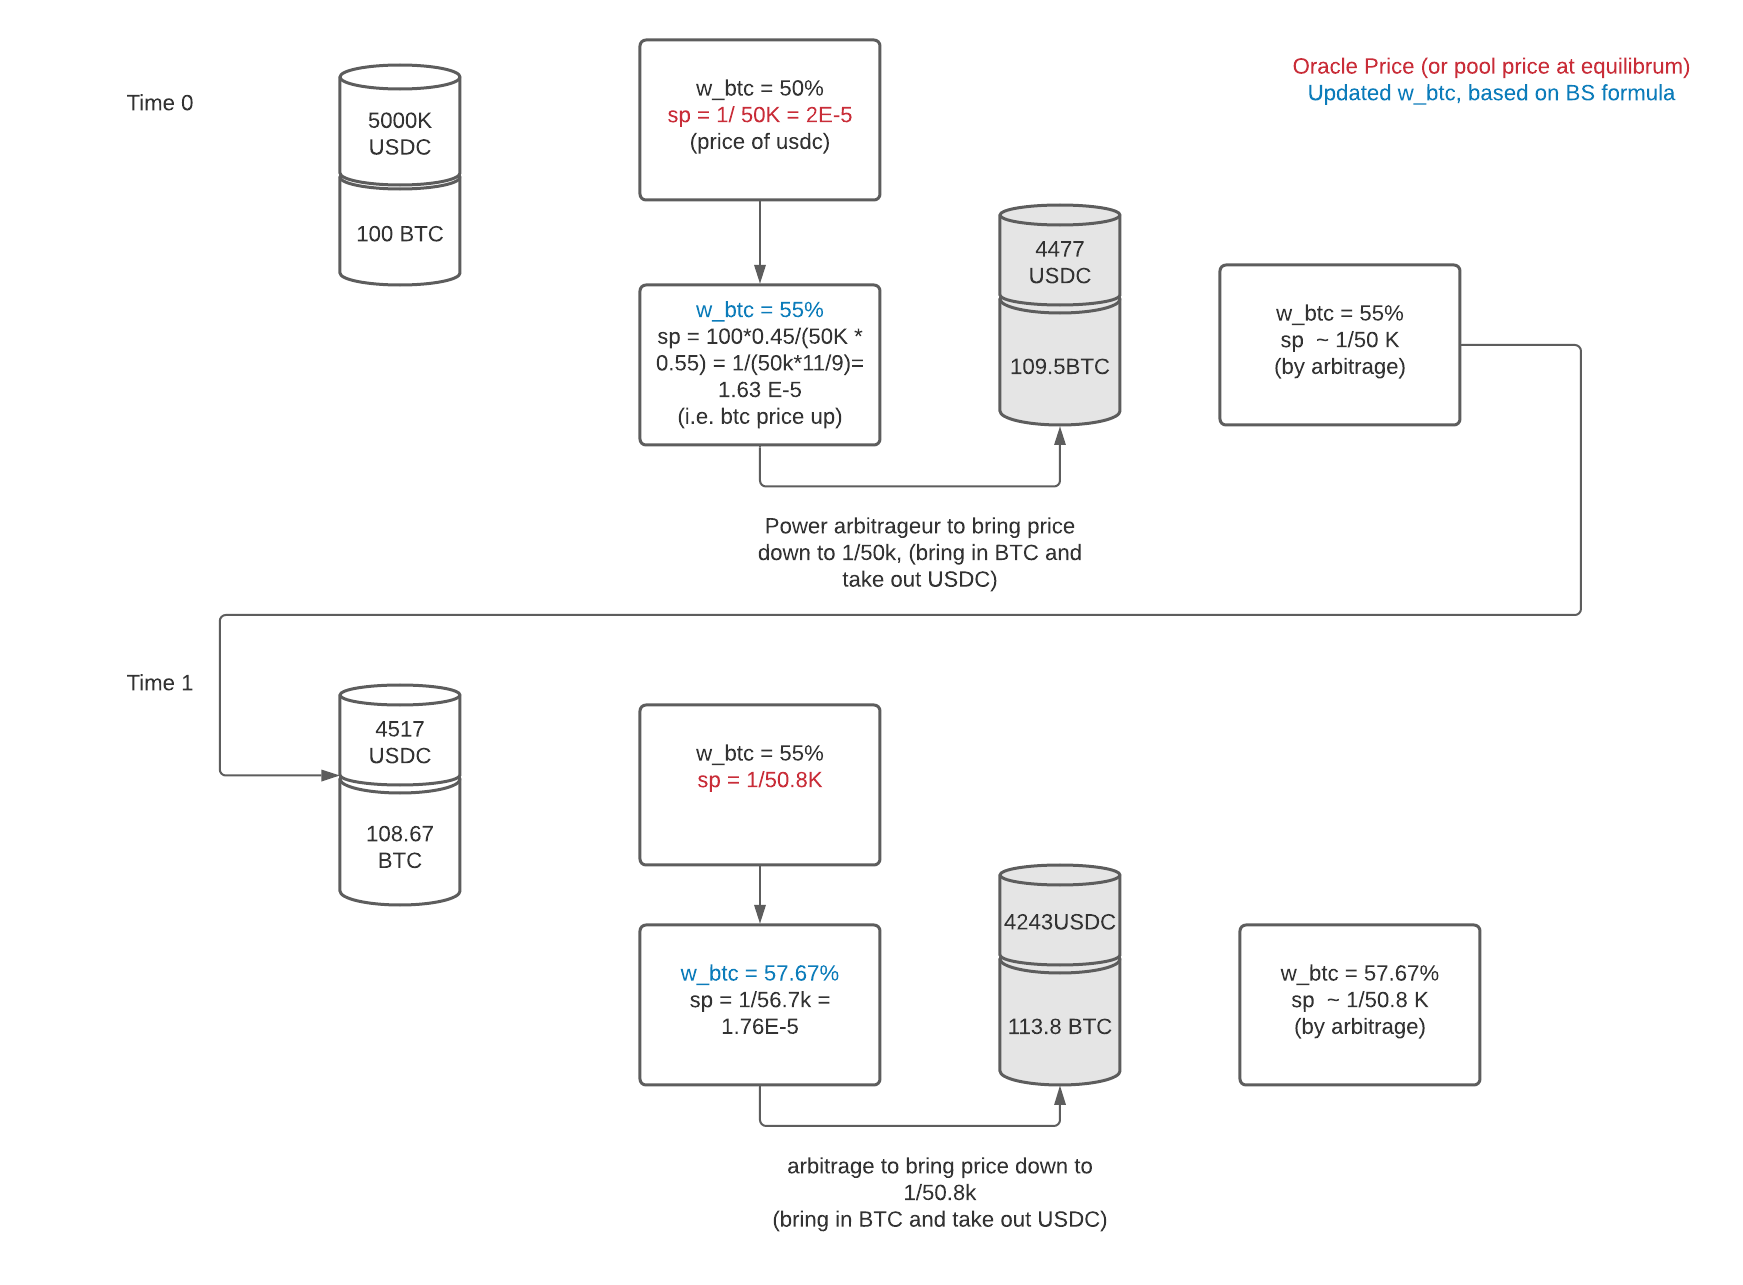

### An illustration of CRP  during time of 2021-05-01 to 2021-07-31. 
<img src="animation_2021-05-01_2021-07-31.gif" width="500" align="center">


# 3.  CRP performance by Simulations  

In this session, we want to simulate how CRP performs in different market environments.  Basically, a CRP would serve as an agent (bot) response to the actual market environment by updating the pool weight based on current token price $p$, actual price volatility $\eta$, and estimated price volatility $\sigma$.  We simplify the market environment and let the token price change follow a linear growth trend with variation, formally named the Geometric Brownian Motion (https://en.wikipedia.org/wiki/Geometric_Brownian_motion).  By setting up different growth rates $r$ and volatility $\eta$, we can approximately mimic different market environments.  

Two metrics a liquidity provider (LP) would be very interested to know are 1) The final pool value relative to the collatrals, and 2) the risk of default, i.e., when the LtV >1 at any time point.  We can empirically estimate the default risk and PVTC for any given parameters by conducting Monte Carlo simulations. 

For simplicity, token APY are not considered for now.  Specially we are focsuing on the exponential moving avager (EMA) approach.    
 
We set the following initial conditions: 

Initial weights = 5L0/50
Loan lifetime = 91 days
LTV0 = 80% 
Realized volatility various from 0.5 to 1.5. 
Assume B-S voliatility equals to Realized volatility. 
EMP factor = 0.95. 


## 3.1 Case 1:  In a BTC upward market, with different realized volatiltiy. 

A | B
- | - 
![alt](pvtc_by_vol_upward.png) | ![alt](default_by_vol_upward.png)

## 3.2 Case 2:  In a BTC flat market, with different realized volatiltiy. 
A | B
- | - 
![alt](pvtc_by_vol_flat.png) | ![alt](default_by_vol_flat.png)

## 3.3 Case 3:  In a BTC downward market, with different realized volatiltiy. 
A | B
- | - 
![alt](pvtc_by_vol_flat.png) | ![alt](default_by_vol_flat.png)

## 3.4 Case 4:  Real BTC downward market (2021-1-01 to 2021-03-31), with different realized volatiltiy. 
A | B
- | - 
![alt](pvtc_by_vol_2021-01-01_2021-03-31.png) | ![alt](default_by_vol_2021-01-01_2021-03-31.png)



## 3.5 Case 5:  Real BTC downward market (2021-4-01 to 2021-06-30), with different realized volatiltiy. 
A | B
- | - 
![alt](pvtc_by_vol_2021-04-01_2021-06-30.png) | ![alt](default_by_vol_2021-04-01_2021-06-30.png)



In [108]:
# plot of liquity 
import scipy 
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.widgets import Slider
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np 
import random
import pandas as pd 
from ipywidgets import *
from scipy.stats import norm
#Import simulation function and class 
%run rbpool_env_v3.ipynb

In [93]:
# an episode example  
t =  np.linspace(91,0,92)/365
Real_vol = 0.75
Growth_rate = 0
LTV0 = 0.8
bs_vol = 0.75
y_price_init = 50000
Collateral = 10000000
pool_init_x = 5000000 
pool_init_y = 100
pool_init_wx = 0.5
fee_rate = 0.0
rebate=0.0
set_random_seed = False  
price_source = [0]
market = 'upward'
example = get_episode_full(t,y_price_init, bs_vol, Growth_rate, Real_vol, Collateral, LTV0, fee_rate, rebate,
                      pool_init_x, pool_init_y, pool_init_wx, price_source,'SM', 0.95)
example.describe()

,t,y_price,weights_ytoken,imp_loss_rebalance,imp_loss_price,x_locked,y_locked,V,coll_with_rebate,rebate,imp_empirical,delta_x,delta_y,ltv_with_rebate,wt_chg,pvtc_rebate
count,92.000000,92.000000,92.000000,9.200000e+01,92.000000,9.200000e+01,92.000000,92.000000,9.200000e+01,92.0,9.200000e+01,92.000000,92.000000,92.000000,92.000000,92.000000
mean,0.124658,57793.588964,0.655112,-9.571738e-05,-0.000146,3.644838e+06,123.147147,7466.833336,1.087508e+07,0.0,-1.655605e-04,-39334.711982,0.616716,0.741710,0.004326,0.946965
std,0.073156,8299.628150,0.114400,1.065255e-04,0.000205,1.019264e+06,16.054544,6607.056806,1.039693e+06,0.0,2.034936e-04,82389.959942,1.443189,0.064671,0.004037,0.045295
min,0.000000,46036.979330,0.503713,-3.678597e-04,-0.000965,1.381206e+06,100.739871,382.787454,9.572577e+06,0.0,-1.020492e-03,-240964.929917,-2.995771,0.564144,-0.005894,0.868394
25%,0.062329,51511.890551,0.541272,-1.627924e-04,-0.000184,3.293258e+06,107.335871,2534.049855,1.009184e+07,0.0,-2.126297e-04,-96894.658293,-0.136832,0.691201,0.001095,0.906971
50%,0.124658,55821.452569,0.649874,-3.782552e-05,-0.000064,3.647734e+06,123.826261,4547.375009,1.059011e+07,0.0,-9.319708e-05,-36976.742201,0.730128,0.755424,0.004176,0.945321
75%,0.186986,63806.077428,0.707089,-9.224128e-06,-0.000019,4.634227e+06,129.792850,14351.566526,1.157406e+07,0.0,-1.714250e-05,8162.145160,1.571430,0.792724,0.007470,0.979312
max,0.249315,81649.367361,0.901705,-8.836163e-10,0.000000,4.962731e+06,156.737843,21480.113275,1.418077e+07,0.0,-5.296322e-08,150221.080258,4.182018,0.835721,0.012045,1.039662


In [116]:
# case 1
t =  np.linspace(91,0,92)/365
set_random_seed = False
Growth_rate = -2
fee_rate = 0.00
rebate = 0
s =5000
Real_vol = 0.75
bs_vol = 0.75
pool_init_wx = 0.5
fee_rate = 0.0
rebate=0
market = 'downward'
print('LTV0 ={}, bs_vol = {}, Real_vol= {}, and growth_rate ={}'.format(LTV0, bs_vol, Real_vol,Growth_rate))


LTV0 =0.8, bs_vol = 0.75, Real_vol= 0.75, and growth_rate =-2


In [117]:
s=5000
set_random_seed = False
for i in np.linspace(0.5,1.5, 21):
    np.random.seed(101)
    Real_vol,bs_vol  = i,i
    _sm = pd.DataFrame(ltv_simulation(s, 'SM', 0.95))
    _sm['vol'] = '{:.2f}'.format(i)
    if i == 0.5:
        SM = _sm
    else:
        SM = pd.concat([SM, _sm])

<IPython.core.display.Javascript object>


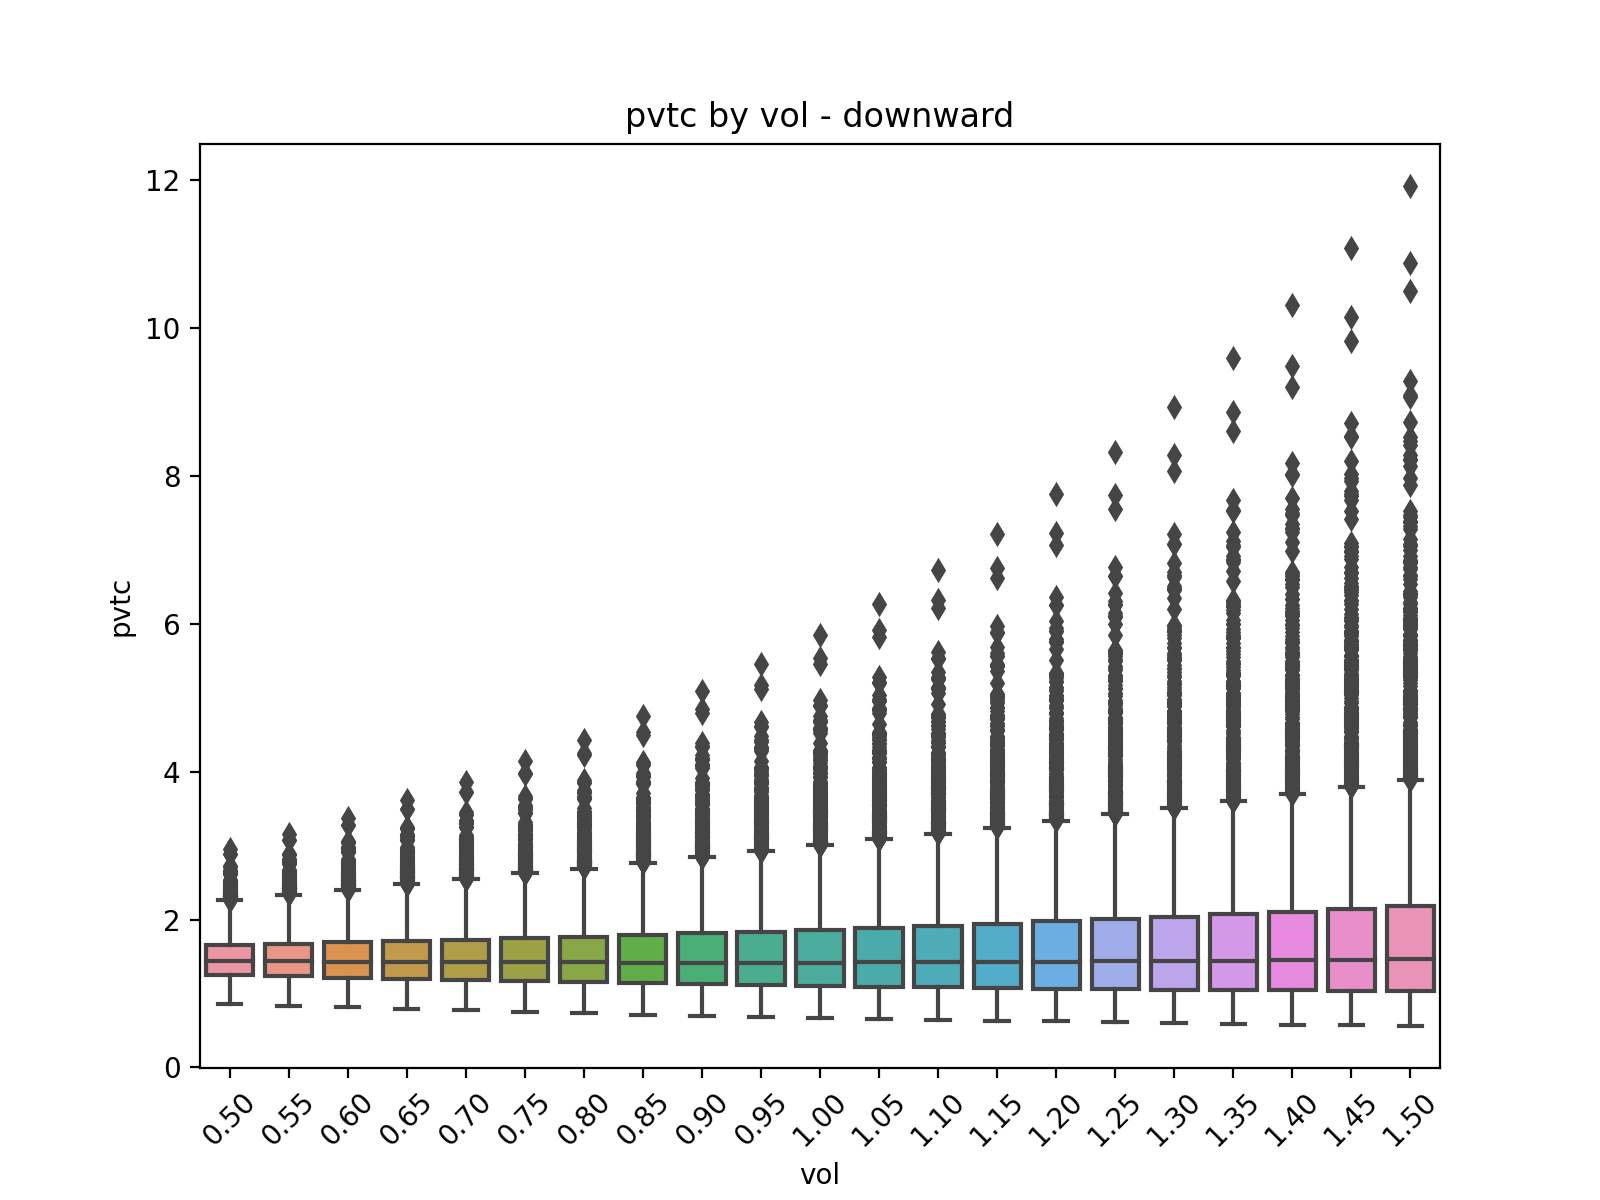

<IPython.core.display.Javascript object>


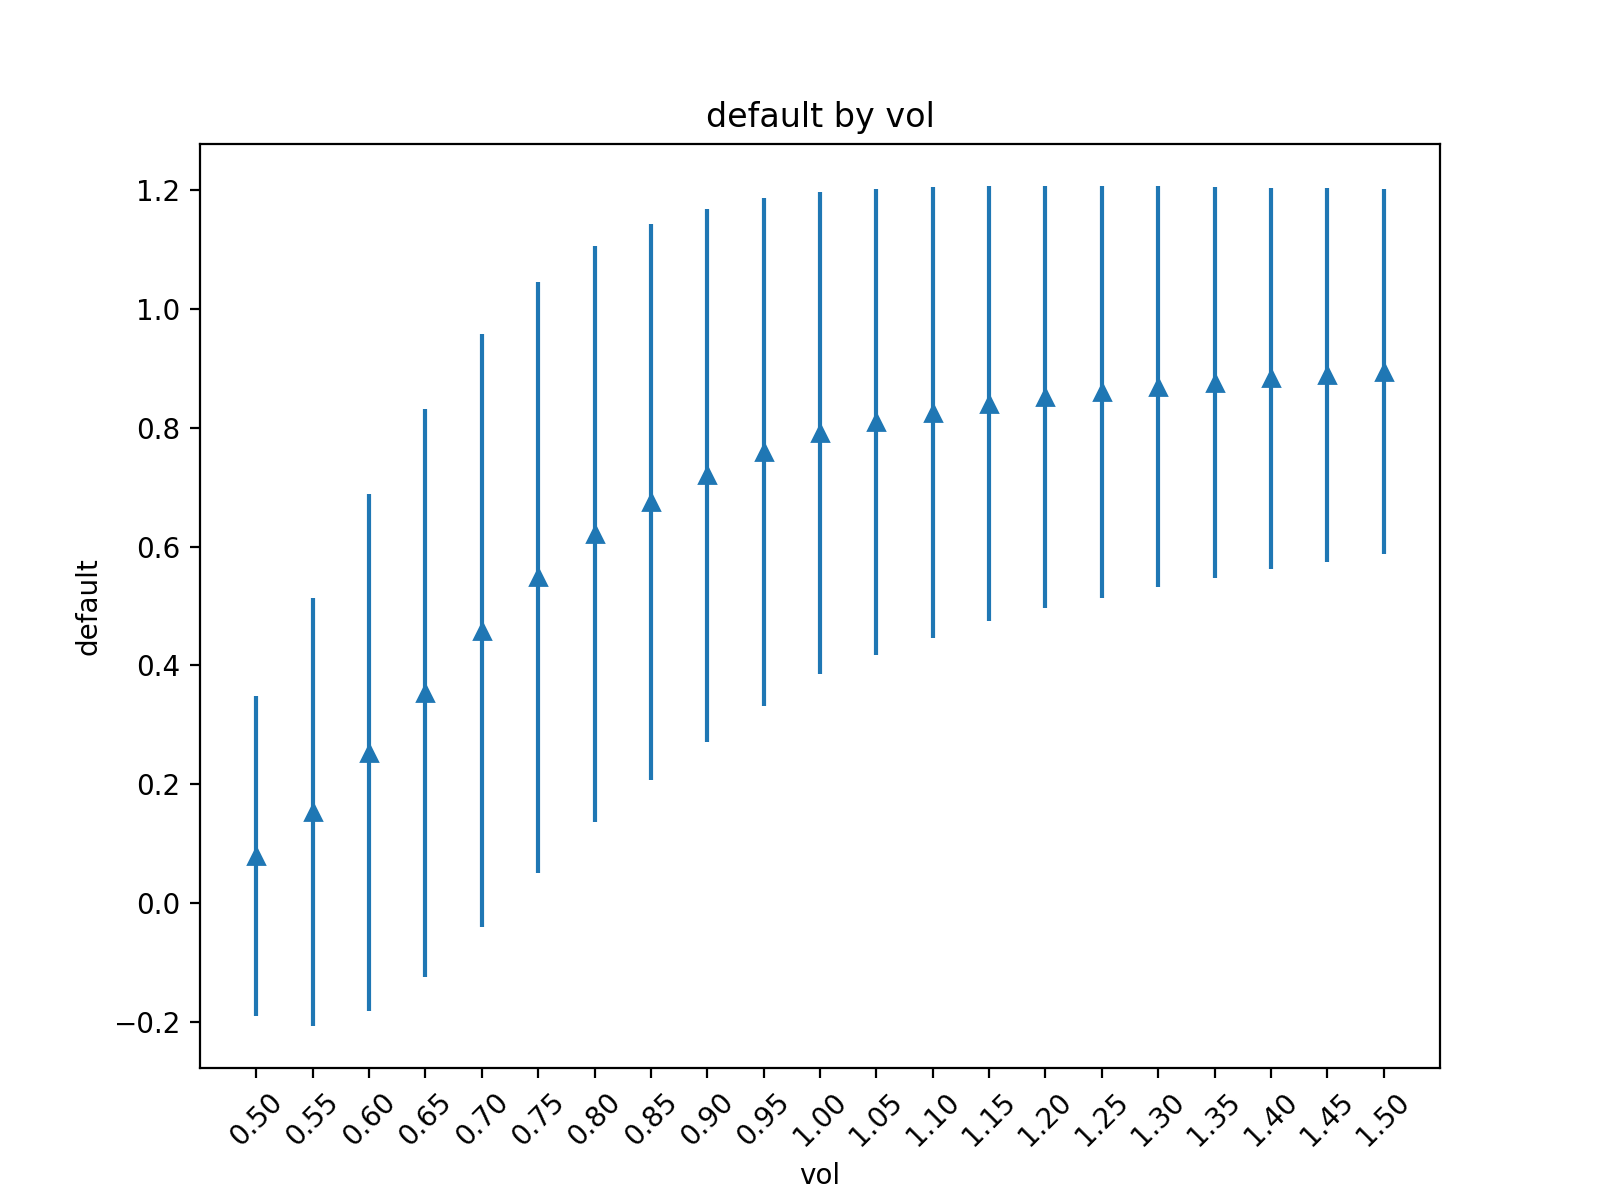

In [118]:
SM.columns = ['loss', 'pool_value', 'pvtc', 'default', 'portfolio', 'vol']
sim_summary(SM, ['pvtc', 'vol'], plot=1).to_csv('sim_SM_pvtc_vol_{}.csv'.format(market))
sim_summary(SM, ['default', 'vol'], plot=2).to_csv('sim_default_vol_{}.csv'.format(market))

In [ ]:
# case 3 vol are inconsistent: 

set_random_seed = False
bs_vol = 0.5
for i in np.linspace(0.5,1.5, 21):
    np.random.seed(101)
    Real_vol = i
    _sm = pd.DataFrame(ltv_simulation(s, 'SM', 0.95))
    _sm['vol'] = i
    if i == 0.5:
        SM = _sm
    else:
        SM = pd.concat([SM, _sm])


In [ ]:
SM.columns = ['loss', 'V', 'pctc', 'default', 'vol']
sim_summary(SM, ['loss', 'vol'], plot=1).to_csv('sim_summary_SM_loss_vol_under_est.csv')
sim_summary(SM, ['V', 'vol'], plot=1).to_csv('sim_summary_SM_Pool_value_vol_under_est.csv')

In [ ]:
set_random_seed = False
bs_vol = 1.5
for i in np.linspace(0.5,1.5, 21):
    np.random.seed(101)
    Real_vol = i
    _sm = pd.DataFrame(ltv_simulation(s, 'SM', 0.95))
    _sm['vol'] = i
    if i == 0.5:
        SM = _sm
    else:
        SM = pd.concat([SM, _sm])
SM.columns = ['loss', 'V', 'pctc', 'default', 'vol']
sim_summary(SM, ['loss', 'vol'], plot=1).to_csv('sim_summary_SM_loss_vol_over_est.csv')
sim_summary(SM, ['V', 'vol'], plot=1).to_csv('sim_summary_SM_Pool_value_vol_over_est.csv')

In [ ]:
# BTC go up and vol go up 
set_random_seed = False
bs_vol = [0.5, 0.75, 1]
Growth_rate= [-1, 0, 1]

i = 0 
for Growth_rate in [-1, 0, 1]:
    for Real_vol in [0.5, 0.75, 1]:
        i+= 1
        bs_vol = Real_vol
        print(Growth_rate,bs_vol, )
        print('grow:'+ str(Growth_rate) + '_' + 'real_vol:'+str(bs_vol))
        np.random.seed(101)
        _sm = pd.DataFrame(ltv_simulation(s, 'SM', 0.95))
        _sm['para'] = 'grow:'+ str(Growth_rate) + '_' + 'real_vol:'+str(bs_vol)
        if i == 1:
            SM = _sm
        else:
            SM = pd.concat([SM, _sm])


In [ ]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#SM.para_value= le.fit_transform(SM.para.values)
SM['para_value']=le.fit_transform(SM.para.values)
labels = SM[['para','para_value']].drop_duplicates().para.values
SM.columns = ['loss', 'V', 'pctc', 'default', 'para', 'para_value']
def plot_boxplt(df, cols, labels=''):
    import matplotlib.pyplot as plt
    import numpy as np
    
    _mean = df.groupby(cols[1]).mean().reset_index()
    _std = df.groupby(cols[1]).std().reset_index()
    fig, ax = plt.subplots(figsize=(8,6))
    ax.errorbar(_mean[cols[1]], _mean[cols[0]], _std[cols[0]], linestyle='None', marker='^')
    ax.set_xlabel(cols[1])
    ax.set_ylabel(cols[0])
    ax.set_title('{} by {}'.format(cols[0], cols[1]))
    plt.show()
plot_boxplt(SM, ['V', 'para_value'], labels)

In [ ]:
labels = SM[['para','para_value']].drop_duplicates()
labels

In [ ]:
SM.columns = ['loss', 'V', 'pctc', 'default', 'para', 'para_value']
sim_summary(SM, ['loss', 'para_value'], plot=1).to_csv('sim_summary_SM_loss_para.csv')
sim_summary(SM, ['V', 'para_value'], plot=1).to_csv('sim_summary_SM_Pool_value_para.csv')




In [36]:
# check on curve 
set_random_seed = False
Growth_rate =2
fee_rate = 0.00
rebate = 0
s =1
Real_vol = 0.75
bs_vol = 0.75
pool_init_wx = 0.5
fee_rate = 0.0
rebate=0.
Growth_rate =2
t =  np.linspace(91,0,92)/365
df_plot = ltv_simulation_path(1, 'SM', 0.95)
df_plot

,t,y_price,weights_ytoken,imp_loss_rebalance,imp_loss_price,x_locked,y_locked,V,coll_with_rebate,rebate,imp_empirical,delta_x,delta_y,ltv_with_rebate,wt_chg,pvtc_rebate,sim_id
0,0.249315,50000.000000,0.503713,-0.000028,0.000000,4.962731e+06,100.739871,21480.113275,9.999724e+06,0.0,-2.757628e-05,-37269.324442,0.739871,0.800022,0.000000,0.999972,0
1,0.246575,49852.213872,0.507065,-0.000022,-0.000001,4.921714e+06,101.555936,20716.191798,9.984502e+06,0.0,-3.343168e-05,-41016.954310,0.816065,0.801242,0.003351,1.001410,0
2,0.243836,48169.155511,0.508394,-0.000004,-0.000147,4.823466e+06,103.555524,20421.230870,9.811648e+06,0.0,-1.932271e-04,-98247.742548,1.999588,0.815357,0.001329,1.018458,0
3,0.241096,49779.439963,0.511391,-0.000018,-0.000135,4.875274e+06,102.503850,19773.890291,9.977858e+06,0.0,-5.544171e-05,51807.767812,-1.051674,0.801775,0.002997,1.002207,0
4,0.238356,50544.756570,0.515032,-0.000027,-0.000029,4.876989e+06,102.469899,19013.514922,1.005631e+07,0.0,-5.873120e-08,1715.481576,-0.033951,0.795521,0.003641,0.994792,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.010959,69643.580516,0.910238,-0.000132,-0.000127,1.085135e+06,158.002332,349.192836,1.208898e+07,0.0,-5.006176e-04,-116229.169051,1.577517,0.661760,0.004724,0.867918,0
88,0.008219,73624.234534,0.914726,-0.000125,-0.000119,1.084512e+06,158.010796,335.617993,1.271794e+07,0.0,-1.619287e-08,-623.334914,0.008464,0.629033,0.004488,0.863706,0
89,0.005479,70695.975332,0.918990,-0.000118,-0.000062,9.924491e+05,159.251265,323.211879,1.225087e+07,0.0,-3.433242e-04,-92062.569252,1.240469,0.653015,0.004264,0.866448,0
90,0.002740,67006.619254,0.923040,-0.000112,-0.000104,8.972173e+05,160.596350,311.973061,1.165824e+07,0.0,-4.164759e-04,-95231.751589,1.345084,0.686210,0.004051,0.869932,0


In [40]:


d = df_plot.index.values
y = df_plot.y_price.values
x,y =[],[]
def animate_line(i):
    d = df_plot.index.values
    y = df_plot.y_price.values
    line.set_data(d[:i],y[:i])
    return line

lst1 = df_plot['x_locked']
lst2 = df_plot['y_price']*df_plot['y_locked']
b1, b2 = [], []
def animate_bar(i):
    lst1 = df_plot['x_locked']
    lst2 = df_plot['y_price']*df_plot['y_locked']
    y1=lst1[i]
    y2=lst2[i]
    ax2.clear()   
    ax2.set_ylim(0,2e7)
    ax2.bar(['USD', 'BTC'], [y1, y2], color =['green', 'yellow'])

def updateAll(i):
    a = animate_line(i)
    b = animate_bar(i)
    return a,b

%matplotlib notebook    
import matplotlib.animation as ani
fig = plt.figure(1)
ax1 = fig.add_subplot(1,2,1, xlim = (0, 92), ylim=(0, 130000))
line, = ax1.plot([],[])
ax1.set_label('BTC price')

ax2 = fig.add_subplot(1,2,2)

ax2.set_ylim(0,2e7)
bar = ax2.bar(['USD', 'BTC'],[0, 0], color=['green', 'yellow'])
animator = ani.FuncAnimation(fig, updateAll, interval=300, blit=False)
plt.show()

f = r'animation.gif'
import matplotlib.animation as animation
writergif = animation.PillowWriter(fps=20) 
animator.save(f, writer=writergif)

<IPython.core.display.Javascript object>

KeyError: 92

In [ ]:
# def buildmebarchart(i = int):
#     p = plt.plot(df_plot[:i].index, df_plot[:i].y_price)

# t = df_plot.index.values
# y = df_plot.y_price.values
# x,y =[],[]
# def animate_line(i):
#     x.append(t[i])
#     y.append(y[i])
#     ax1.plot(x,y, scaley=True, scalex =True, color = 'blue')
    
# lst1 = df_plot['x_locked']
# lst2 = df_plot['y_price']*df_plot['y_locked']
# b1, b2 = [], []
# def animate_bar(i):
#     y1=lst1[i]
#     y2=lst2[i]
#     ax2.bar(['USD', 'BTC'], [y1, y2], color =['green', 'yellow'])

# %matplotlib notebook    
# import matplotlib.animation as ani
# fig = plt.figure(figsize=(8,6))
# plt.style.use('seaborn')
# ax1 = fig.add_subplot(1,2,1)
# ax1.set_ylim(0, 130000)
# ax1.set_xlim(0, 92)
# animator1 = ani.FuncAnimation(fig, buildmebarchart, interval = 100)

# ax2 = fig.add_subplot(1,2,2)
# ax2.set_ylim(0,2e7)
# animator2 = ani.FuncAnimation(fig, animate_bar, interval=100)
# plt.show()

In [ ]:
# set_random_seed = False
# for i in np.linspace(0.70, 0.99, 30):
#     np.random.seed(101)
#     _sm = pd.DataFrame(ltv_simulation(s, 'SM', i))
#     _sm['factor'] = i
#     if i == 0.7:
#         SM = _sm
#     else:
#         SM = pd.concat([SM, _sm])
# SM.columns = ['loss', 'V', 'pctc', 'default', 'factor']
# sim_summary(SM, ['loss', 'factor'], plot=1).to_csv('sim_summary_SM_loss.csv')
# sim_summary(SM, ['V', 'factor'], plot=1).to_csv('sim_summary_SM_Pool_value.csv')        

In [ ]:
# for i in np.arange(10)+1:
#     np.random.seed(101)
#     _ma = pd.DataFrame(ltv_simulation(s, 'MA', i))
#     _ma['ma_window'] = i
#     if i == 1:
#         MA = _ma
#     else:
#         MA = pd.concat([MA,_ma])

# MA.columns = ['loss', 'V', 'pctc', 'default', 'ma_window']
# sim_summary(MA, ['V', 'ma_window'], plot=1).to_csv('sim_summary_MA_Pool_value.csv')
# sim_summary(MA, ['loss', 'ma_window'], plot=1).to_csv('sim_summary_MA_loss.csv')

In [ ]:
# set_random_seed = False
# Growth_rate = 0
# fee_rate = 0.00
# rebate = 0.8
# s =5000
# Real_vol = 0.75
# bs_vol = 0.75
# pool_init_wx = 0.5
# fee_rate = 0.0
# rebate=0.
# print(LTV0, bs_vol, Growth_rate, Real_vol)
set_random_seed = False
s=5000
np.random.seed(42)
BS = pd.DataFrame(ltv_simulation(s, 'BS'))
np.random.seed(42)
MA = pd.DataFrame(ltv_simulation(s, 'MA',7))
np.random.seed(42)
SM = pd.DataFrame(ltv_simulation(s, 'SM', 0.95))
np.random.seed(42)
Uni = pd.DataFrame(ltv_simulation(s, '50/50'))
# plt.figure(figsize=(10,8))
# plt.hist(sim_1000.PVTC_bs, bins=100, alpha=0.5, label="BS")
# plt.hist(sim_1000.PVTC_ma7, bins=100, alpha=0.5, label="MA(7)")
# plt.hist(sim_1000.PVTC_sm, bins=100, alpha=0.5, label="SM")
# plt.hist(sim_1000.PVTC_uni, bins=100, alpha=0.5, label="Uni")
# plt.title("Histograms of PVtC")
# plt.legend(loc='upper right')

In [ ]:
set_random_seed

In [ ]:

BS.columns = ['loss','Pool value', 'PVTC', 'Portfolio']
BS['rebalance'] = 'BS'
MA.columns =  ['loss','Pool value', 'PVTC', 'Portfolio']
MA['rebalance'] = 'MA(7)'
SM.columns =  ['loss','Pool value', 'PVTC', 'Portfolio']
SM['rebalance'] = 'SM_0.95'
Uni.columns =  ['loss','Pool value', 'PVTC', 'Portfolio']
Uni['rebalance'] = '50/50'
sim_5000 = pd.concat([BS, MA, SM, Uni], axis=0)
sim_5000.head()
# plt.figure(figsize=(10,8))
# plt.hist(sim_1000.PVTC_bs, bins=100, alpha=0.5, label="BS")
# plt.hist(sim_1000.PVTC_ma7, bins=100, alpha=0.5, label="MA(7)")
# plt.hist(sim_1000.PVTC_sm, bins=100, alpha=0.5, label="SM")
# plt.hist(sim_1000.PVTC_uni, bins=100, alpha=0.5, label="Uni")
# plt.title("Histograms of PVtC")
# plt.legend(loc='upper right')

In [ ]:
sim_summary(sim_5000, ['Pool value', 'rebalance'], plot=1)
sim_5000.groupby('rebalance')['Pool value'].skew()
BS['Pool value'].mean()

In [ ]:
sim_summary(sim_5000, ['Pool value', 'rebalance'], plot=1).to_csv('sim_summary_Pool_value1.csv')
sim_summary(sim_5000, ['loss', 'rebalance'], plot=1).to_csv('sim_summary_loss1.csv')
sim_summary(sim_5000, ['Portfolio', 'rebalance'], plot=1).to_csv('sim_summary_portfolio1.csv')

In [ ]:
sim_out = pd.DataFrame(np.concatenate([BS.mean(), MA.mean(), SM.mean(), Uni.mean()]).reshape(4,-1), columns= ['Q', 'PVTC', 'default rate'], \
            index = ['BS', 'MA', 'SM', '50/50'])
sim_out

In [ ]:
BS

In [ ]:
set_random_seed = False
Growth_rate =0
fee_rate = 0
rebate = 0
s =5000
print(LTV0, bs_vol, Growth_rate, Real_vol)
np.random.seed(42)
BS_path = pd.DataFrame(ltv_simulation_path(s, 'BS'))
np.random.seed(42)
MA_path = pd.DataFrame(ltv_simulation_path(s, 'MA', 7))
np.random.seed(42)
SM_path = pd.DataFrame(ltv_simulation_path(s, 'SM', 0.95))
np.random.seed(42)
Uni_path = pd.DataFrame(ltv_simulation_path(s, '50/50'))

In [ ]:
BS_path[['sim_id', 't', 'y_price', 'weights_ytoken', 'V', 'coll_with_rebate', 'ltv_with_rebate', 'pvtc_rebate']].to_csv('BS_path.csv', index=False)

In [ ]:
temp = BS_path.loc[BS_path.sim_id == 0]
temp.to_csv('BS_path_long.csv', float_format='%.30f')

In [ ]:
BS_path[['sim_id', 't', 'y_price', 'weights_ytoken', 'V', 'coll_with_rebate', 'ltv_with_rebate', 'pvtc_rebate']].shape

In [ ]:
Uni_path[['sim_id', 't', 'y_price', 'weights_ytoken', 'V', 'coll_with_rebate']]

In [ ]:
Growth_rate =1
_simulation = ltv_simulation(1000, LTV0, bs_vol, Growth_rate, Real_vol)